## CS 445: Computational Photography

## Programming Project #3: Gradient Domain Fusion

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

## Part 1 Toy Problem (20 pts)

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time
import scipy
from scipy.sparse import lil_matrix
import scipy.sparse.linalg

# modify to where you store your project data including utils.py
datadir = "./" 

utilfn = datadir + "utils.py"
!cp "$utilfn" .
samplesfn = datadir + "samples"
!cp -r "$samplesfn" .
import utils


cp: './utils.py' and './utils.py' are the same file
cp: './samples' and './samples' are the same file


In [23]:
def toy_reconstruct(img):
    """
    The implementation for gradient domain processing is not complicated, but it is easy to make a mistake, so let's start with a toy example. Reconstruct this image from its gradient values, plus one pixel intensity. 
    Denote the intensity of the source image at (x, y) as s(x,y) and the value to solve for as v(x,y). For each pixel, then, we have two objectives:
    1. minimize (v(x+1,y)-v(x,y) - (s(x+1,y)-s(x,y)))^2
    2. minimize (v(x,y+1)-v(x,y) - (s(x,y+1)-s(x,y)))^2
    Note that these could be solved while adding any constant value to v, so we will add one more objective:
    3. minimize (v(1,1)-s(1,1))^2

    The first step is to write the objective function as a set of least squares constraints in the standard matrix form: (Av-b)^2. Here, "A" is a sparse matrix, "v" are the variables to be solved, and "b" is a known vector. 
    Especially for blending with irregular masks, it is helpful to keep a matrix im2var that maps each pixel to a variable number, such as:
    
    im_h, im_w = im.shape
    im2var = np.arange(im_h * im_w).reshape(im_h, im_w)
    
    Then, you can write objective 1 above as:
    e = e + 1;
    A[e][im2var[y][x+1]] = 1
    A[e][im2var[y][x]] = -1
    b[e] = im[y][x+1] - im[y][x]
    Here, "e" is used as an equation counter. Note that the y-coordinate is the first index. As another example, objective 3 above can be written as:
    e = e + 1;
    A[e][im2var[0][0]] = 1
    b[e] = s[0][0]
    
    To solve for v, use v = scipy.sparse.linalg.lsqr(A, b); Then, copy each solved value to the appropriate pixel in the output image.
    
    :param toy_img: numpy.ndarray
    """

    # alright, so what do we want to do, in simple terms?

    # We need to figure out A and b, then use them to solve for v

    # A is going to be our gradient matrix: capturing the gradients from the source pixels in relation to their neighbors in a specific way
    # b is going to be what we want our gradient to actually equal
    # that leaves v, which are the pixel values that are applied to our gradient matrix in order to return b. Av = b

    # we need a mapping vector. This will be in the shape of our image but just count from 0 to total # of pixels
    im_h, im_w = img.shape
    im2var = np.arange(im_h * im_w).reshape(im_h, im_w)

    num_equations = ((im_h-1) * im_w)*2 # in gradient domain processing, each pixel will require 2 equations. Thus the # of equations needed = # of pixels * 2
    total_vars = im_h * im_w            # Number of variables in v. These are the pixel values, so we need a variable for every pixel we are solving for
    
    A = lil_matrix((num_equations, total_vars)) # create zero matrices for A and b
    b = np.zeros(num_equations)

    # now, it is time to fill A and b

    # objective 1: horizontal gradients
    
    e = 0  # Initialize equation index
    
    for y in range(im_h):                     # Iterate over the rows
        for x in range(im_w - 1):             # Iterate over columns, excluding the last column as it has no gradient
            A[e, im2var[y, x + 1]] = 1        # Positive contribution from the pixel to the right
            A[e, im2var[y, x]] = -1           # Negative contribution from the pixel to the left
            b[e] = img[y, x + 1] - img[y, x]  # Fill in the target difference for the gradient
            e += 1                            # Increment the equation number for each gradient equation
            
    for y in range(im_h - 1):                 # Iterate over rows, excluding the last row
        for x in range(im_w):                 # Iterate over all columns
            A[e, im2var[y + 1, x]] = 1        # Positive contribution from the pixel below
            A[e, im2var[y, x]] = -1           # Negative contribution from the pixel above
            b[e] = img[y + 1, x] - img[y, x]  # Fill in the target difference for the gradient
            e += 1                            # Increment the equation number for each gradient equation
    
    A[e][im2var[0][0]] = 1       # Set the coefficient for v[0][0] to 1
    b[e] = im2var[0][0]          # Set the target value from the source image
    e += 1                       # Move to the next equation
    
    # solve for v
    v = scipy.sparse.linalg.lsqr(A, b)[0]  # Retrieve the solution vector

    return v.reshape(im_h, im_w)           # Reshape the flattened array back to the original image dimensions

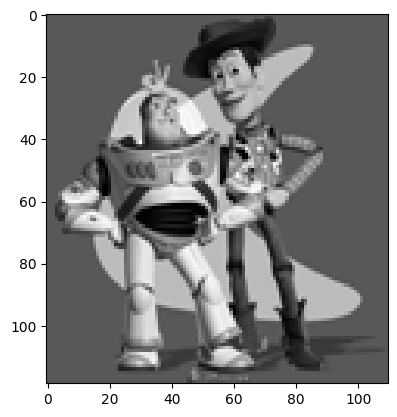

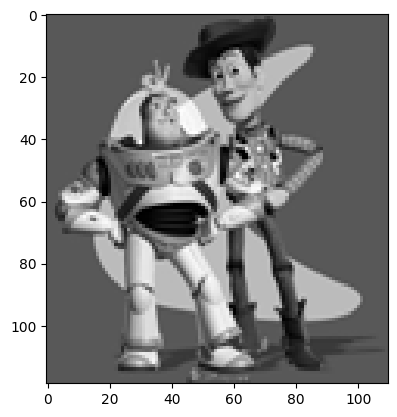

Max error is:  0.42678487112777425


In [24]:
toy_img = cv2.cvtColor(cv2.imread('samples/toy_problem.png'), cv2.COLOR_BGR2GRAY).astype('double') / 255.0
plt.imshow(toy_img, cmap="gray")
plt.show()

im_out = toy_reconstruct(toy_img)
plt.imshow(im_out, cmap="gray")
plt.show()
print("Max error is: ", np.sqrt(((im_out - toy_img)**2).max()))

## Preparation

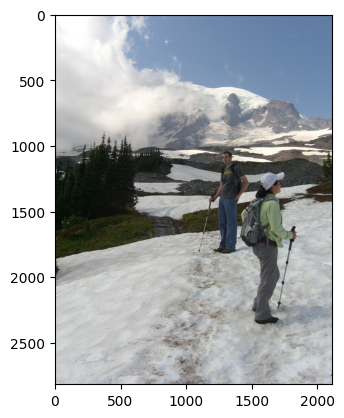

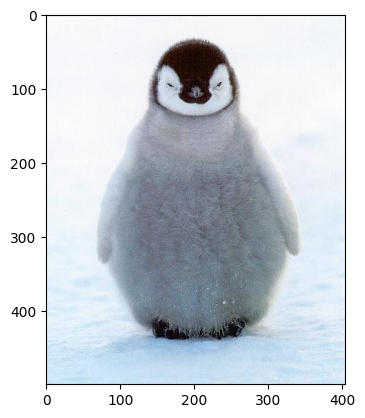

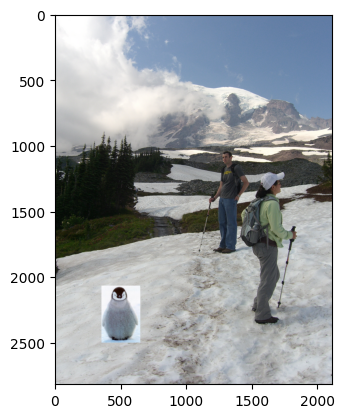

In [7]:
background_img = cv2.cvtColor(cv2.imread('samples/im2.JPG'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img)
plt.show()
object_img = cv2.cvtColor(cv2.imread('samples/penguin-chick.jpeg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.imshow(object_img)
plt.show()

use_interface = False  # set to true if you want to use the interface to choose points (might not work in Colab)
if not use_interface:
  xs = (65, 359, 359, 65)
  ys = (24, 24, 457, 457)
  object_mask = utils.get_mask(ys, xs, object_img)
  bottom_center = (500, 2500) # (x,y)

  object_img, object_mask = utils.crop_object_img(object_img, object_mask)
  bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
  plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))


In [10]:
if use_interface:
  import matplotlib.pyplot as plt
  %matplotlib notebook
  mask_coords = specify_mask(object_img)

In [11]:
if use_interface:
  xs = mask_coords[0]
  ys = mask_coords[1]
  %matplotlib inline
  import matplotlib.pyplot as plt
  plt.figure()
  object_mask = get_mask(ys, xs, object_img)

In [12]:
if use_interface:
  %matplotlib notebook
  import matplotlib.pyplot as plt
  bottom_center = specify_bottom_center(background_img)
  %matplotlib inline
  import matplotlib.pyplot as plt

  object_img, object_mask = utils.crop_object_img(object_img, object_mask)
  bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
  plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))



## Part 2 Poisson Blending (50 pts)

Step 1: Select source and target regions. Select the boundaries of a region in the source image and specify a location in the target image where it should be blended. Then, transform (e.g., translate) the source image so that indices of pixels in the source and target regions correspond. The provided utils.py includes functions for this. You may want to augment the code to allow rotation or resizing into the target region. You can be a bit sloppy about selecting the source region -- just make sure that the entire object is contained. Ideally, the background of the object in the source region and the surrounding area of the target region will be of similar color.

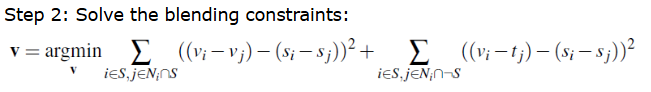

Step 3: Copy the solves values into your target image. For RGB images, process each channel separately.

Given the instructions above - what are we supposed to do? And how does this relate to the toy problem?

1) Create the ability for a user to specficy region in the source and target image via an interface. This will be selecting the region in the source where the penguin is, and the region in the target where we want to place the penguin. Actually, this is in utils, and it doesn't even work for me - so I will manually just use the coordinates provided
2) Calculate a correspondence between these two areas. Let's just assume that the region we select from the source will always be smaller, both in terms of width and height, than the region we are placing. Given that constraint, we could just select an region from the target image randomly that is the size of the region we picked from the source image
3) Solve for the blending constraints: how do we alter the pixels from our target region to blend with the pixels of our source region?
    - do what we did with the toy problem, essentially
4) Return the target image

In [67]:
import numpy as np
import scipy.sparse
from scipy.sparse.linalg import lsqr
import cv2
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import cg

def poisson_blend(object_img, object_mask, bg_img, bg_ul):
    """
    Returns a Poisson blended image with masked object_img over the bg_img at position specified by bg_ul.
    Can be implemented to operate on a single channel or multiple channels
    
    :param object_img: the image containing the foreground object (penguin)
    
    :param object_mask: the mask of the foreground object in object_img
    
    :param background_img: the background image 
    
    :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img 
    """
    # we are given all the parameters we need
    
    # object_img: the penguin
    # object_mask: the mask of the penguin
    # bg_img:      the skiing image we place the penguin into
    # bg_ul:       the top left corner of where we are placing the penguin in the target image

    # plt.imshow(object_img)
    # plt.show()

    # get dimensions of object and background
    obj_h, obj_w = object_img.shape[:2]
    bg_h, bg_w = bg_img.shape[:2]

    # define region we are looking at in the background image
    bg_y, bg_x = bg_ul
    roi_bg = bg_img[bg_y:bg_y + obj_h, bg_x:bg_x + obj_w]

    # remember:
    # A is going to be a 1, -1 matrix that encodes the relationship between pixels in the object image
    # b is going to be the desired pixel gradients we want to have, taken mostly from the object image, but also a few
    # taken from the location in the target we are placing into

    # in essence, we are going to figure out what pixel values we need in v, based off of the desired gradients. A is easy
    # to encode, as it is just specifying the coefficents of differences between pixel values. Thus, it is entirely 1's and
    # 0's. If we just decided to recreate our penguin image, we would want to know the gradients of the original image, and 
    # our extra constraint would be that the pixel value of our new recreated image needs to equal our old penguin image.

    # this is where things differ from the toy problem. Our extra constraints enable us to alter the image to blend with 
    # the background target image. By setting a few extra constraints, we can ensure that the pixels in v are bounded 
    # by the constraints of b

    # as mentioned before, the majority of the equations we solve are relating to gradients. Gradient information stored in
    # A combines with a computed gradient difference which is stored in b. Solving these together gives us a pixel that 
    # satisifies the constraints and we place that in v
    
    # for those values that we manually pick, which are actually just pixel intensities (rather than gradients), we are
    # not solving a gradient equation. Our combination of A and b to get v is simply saying "at this specific equation,
    # we need the value of v to be equal to the pixel intensity we observe in the target image"

    # solving this whole system of equations results in a set of pixel intensities that are constrained by the gradients
    # and the desired pixel values we picked from the background target image

    # create mapping variable
    im2var = np.arange(obj_h * obj_w).reshape(obj_h, obj_w) # it will be the size of our penguin image length by width
    
    # count number of equations
    num_equations = (obj_h - 1) * obj_w + (obj_w - 1) * obj_h + 3  # Horizontal + Vertical + one intensity constraint, just like before in the toy problem
    total_vars = obj_h * obj_w
    
    # initialize the sparse matrix A and vector b
    A = scipy.sparse.lil_matrix((num_equations, total_vars))
    b = np.zeros(num_equations)

    # fill the sparse matrix A and vector b for the gradients
    e = 0  

    # horizontal gradients
    for y in range(obj_h):
        for x in range(obj_w - 1):
            A[e, im2var[y, x + 1]] = 1
            A[e, im2var[y, x]] = -1
            b[e] = object_img[y, x + 1] - object_img[y, x]
            e += 1

    # vertical gradients
    for y in range(obj_h - 1):
        for x in range(obj_w):
            A[e, im2var[y + 1, x]] = 1
            A[e, im2var[y, x]] = -1
            b[e] = object_img[y + 1, x] - object_img[y, x]
            e += 1

    # fefine the pixel positions for intensity preservation in background target image
    points = [
        (0, 0),              # Top-left
        (0, obj_w - 1),     # Top-right
        (obj_h - 1, 0)     # Bottom-left
        # (obj_h - 1, obj_w - 1),  # Bottom-right
        # (20, 20),           # Additional point 
        # (25, 50)           # Additional point 
    ]
    
    # loop through each point and set up the constraints
    for point in points:
        y, x = point  
        A[e, im2var[y, x]] = 1                  # coefficient for the pixel in the variable vector
        b[e] = roi_bg[y, x]                     # Align with the background intensity at the point
        e += 1 
    
    # now, solving Av = b
    v, _ = cg(A.T @ A, A.T @ b)  # fastest method I found
    v = np.clip(v, 0, 255) 
    v = v.reshape(obj_h, obj_w)

    # place v into the background target image
    output_img = bg_img.copy()
    output_img[bg_y:bg_y + obj_h, bg_x:bg_x + obj_w] = v 
    
    return output_img

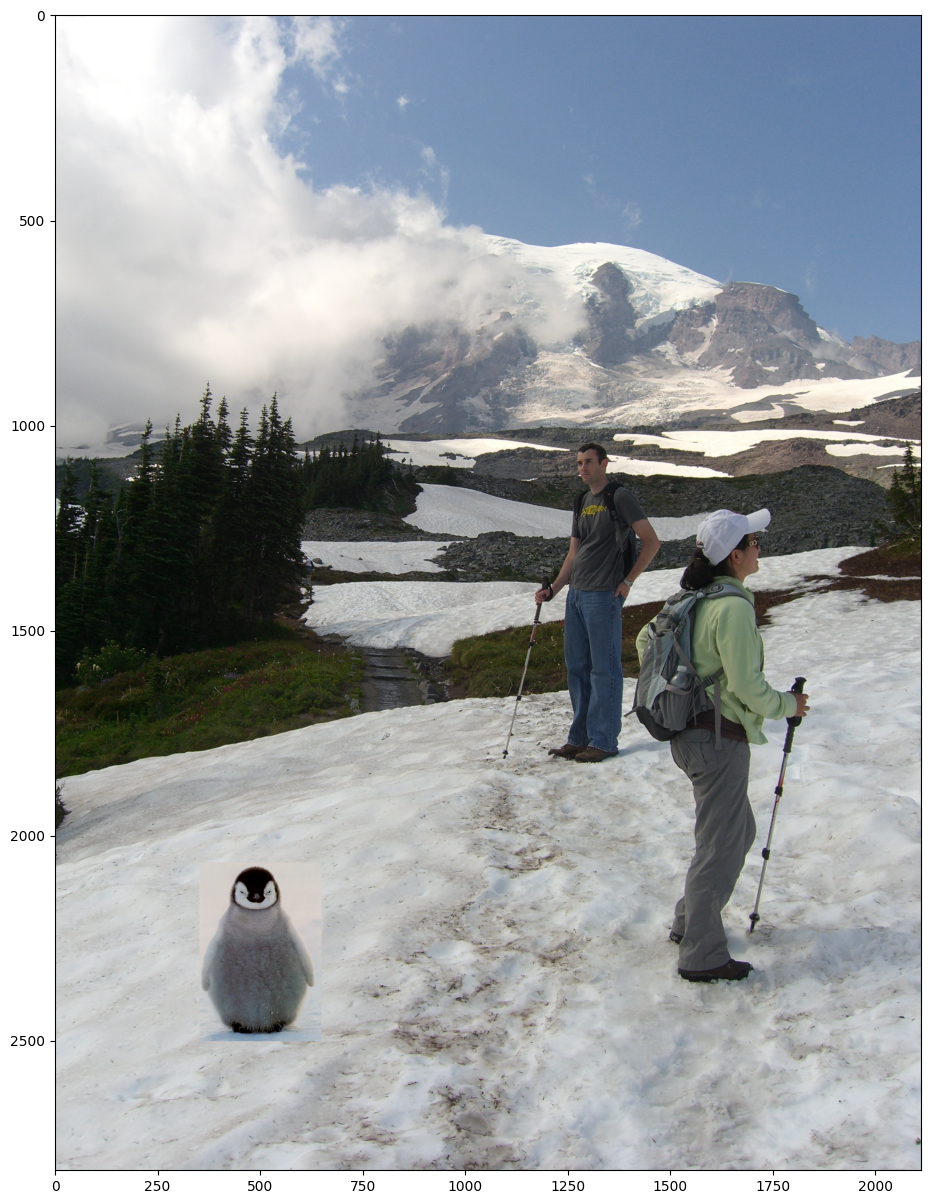

In [68]:
%matplotlib inline

im_blend = np.zeros(background_img.shape)
for b in np.arange(3):
  im_blend[:,:,b] = poisson_blend(object_img[:,:,b], object_mask, background_img[:,:,b].copy(), bg_ul)

plt.figure(figsize=(15,15))
plt.imshow(im_blend)

I think this is correctly done. This is probably the best we can do with a rectangular mask around the penguin. Better performance would be expected with a better mask.

## Part 3 Mixed Gradients (20 pts)

In [105]:
import numpy as np
import scipy.sparse
from scipy.sparse.linalg import cg

def compute_gradients(image):
    padded_img = np.pad(image, ((0, 1), (0, 1)), mode='edge')
    grad_x = padded_img[1:, :-1] - padded_img[:-1, :-1]  # Horizontal gradient
    grad_y = padded_img[:-1, 1:] - padded_img[:-1, :-1]  # Vertical gradient
    return grad_x, grad_y

def mixed_blend(object_img, object_mask, bg_img, bg_ul):
    """
    Returns a Poisson blended image with masked object_img over the bg_img at position specified by bg_ul
    using mixed gradients from both the object and background images.

    :param object_img: the image containing the foreground object (e.g., writing)
    :param object_mask: the mask of the foreground object in object_img
    :param bg_img: the background image where the object will be blended
    :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img 
    """
    # Get dimensions of object and background
    obj_h, obj_w = object_img.shape[:2]
    bg_h, bg_w = bg_img.shape[:2]

    # Define the region we are looking at in the background image
    bg_y, bg_x = bg_ul
    roi_bg = bg_img[bg_y:bg_y + obj_h, bg_x:bg_x + obj_w]

    # Compute gradients for both images
    grad_obj_x, grad_obj_y = compute_gradients(object_img)
    grad_bg_x, grad_bg_y = compute_gradients(roi_bg)

    # Create mapping variable
    im2var = np.arange(obj_h * obj_w).reshape(obj_h, obj_w)
    
    # Count number of equations
    num_equations = (obj_h - 1) * obj_w + (obj_w - 1) * obj_h + 3  # Horizontal + Vertical + constraints
    total_vars = obj_h * obj_w
    
    # Initialize the sparse matrix A and vector b
    A = scipy.sparse.lil_matrix((num_equations, total_vars))
    b = np.zeros(num_equations)

    e = 0  

    # Horizontal mixed gradients
    for y in range(obj_h):
        for x in range(obj_w - 1):
            # Calculate gradients
            obj_grad = grad_obj_x[y, x + 1] - grad_obj_x[y, x]
            bg_grad = grad_bg_x[y, x + 1] - grad_bg_x[y, x]

            # Use the gradient with the larger magnitude
            if abs(obj_grad) > abs(bg_grad):
                A[e, im2var[y, x + 1]] = 1
                A[e, im2var[y, x]] = -1
                b[e] = obj_grad
            else:
                A[e, im2var[y, x + 1]] = 1
                A[e, im2var[y, x]] = -1
                b[e] = bg_grad
            e += 1

    # Vertical mixed gradients
    for y in range(obj_h - 1):
        for x in range(obj_w):
            obj_grad = grad_obj_y[y + 1, x] - grad_obj_y[y, x]
            bg_grad = grad_bg_y[y + 1, x] - grad_bg_y[y, x]

            # Use the gradient with the larger magnitude
            if abs(obj_grad) > abs(bg_grad):
                A[e, im2var[y + 1, x]] = 1
                A[e, im2var[y, x]] = -1
                b[e] = obj_grad
            else:
                A[e, im2var[y + 1, x]] = 1
                A[e, im2var[y, x]] = -1
                b[e] = bg_grad
            e += 1

    # Add fixed intensity constraints
    points = [
        (0, 0),              # Top-left
        (0, obj_w - 1),     # Top-right
        (obj_h - 1, 0)      # Bottom-left
    ]
    
    # Loop through each point and set up the constraints
    for point in points:
        y, x = point  
        A[e, im2var[y, x]] = 1                  
        b[e] = roi_bg[y, x]                     
        e += 1 
    
    # Now, solving Av = b
    v, _ = cg(A.T @ A, A.T @ b)
    v = np.clip(v, 0, 255) 
    v = v.reshape(obj_h, obj_w)

    # Place v into the background target image
    output_img = bg_img.copy()
    output_img[bg_y:bg_y + obj_h, bg_x:bg_x + obj_w] = v 
    
    return output_img

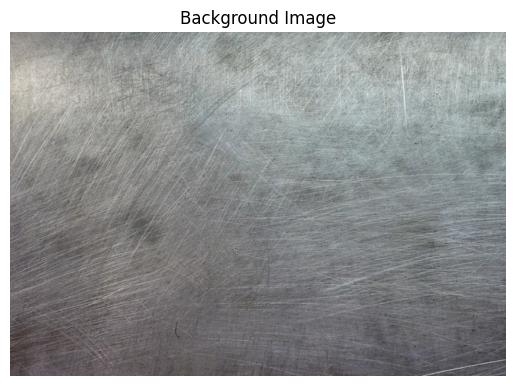

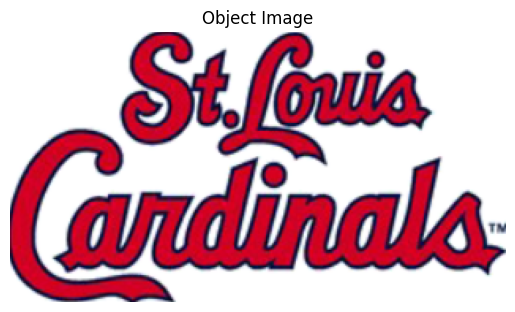

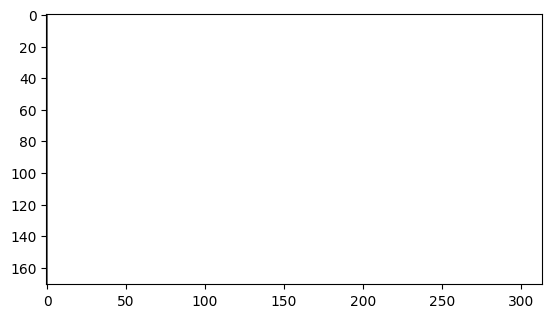

In [139]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load images
background_img = cv2.cvtColor(cv2.imread('samples/metal.png'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
object_img = cv2.cvtColor(cv2.imread('samples/cardinals.png'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 

# Display images
plt.figure()
plt.imshow(background_img)
plt.title("Background Image")
plt.axis("off")
plt.show()

plt.figure()
plt.imshow(object_img)
plt.title("Object Image")
plt.axis("off")
plt.show()

# Define coordinates for the mask (make sure these coordinates are correct)
xs = (1, 359, 359, 1)
ys = (0, 0, 359, 359)
   

# Create the object mask using your utils function
object_mask = utils.get_mask(ys, xs, object_img)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.08789434151519432..1.0879766597008906].


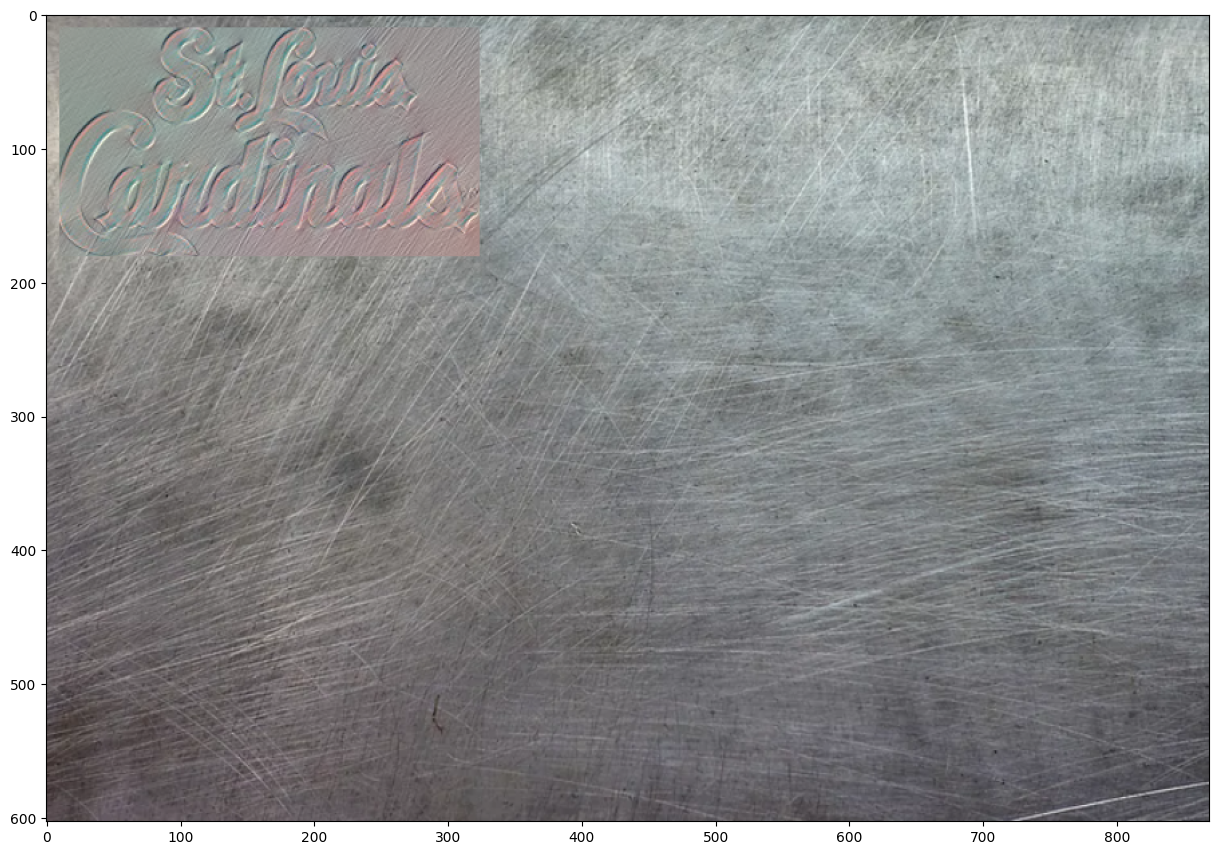

In [140]:
im_mix = np.zeros(background_img.shape)
for b in np.arange(3):
  im_mix[:,:,b] = mixed_blend(object_img[:,:,b], object_mask, background_img[:,:,b].copy(), bg_ul)

plt.figure(figsize=(15,15))
plt.imshow(im_mix)

# Bells & Whistles (Extra Points)

## Color2Gray (20 pts)

In [ ]:
def color2gray(img):
    pass

## Laplacian pyramid blending (20 pts)

In [ ]:
def laplacian_blend(object_img, object_mask, bg_img, bg_ul):
  # feel free to change input parameters
    pass

## More gradient domain processing (up to 20 pts)